<div align="center">

#**Spoken Language Processing - Spring 2024/2025**

##**Course Project**


### **Students:**  
**Noor Shamali 1200016** <br>
**Dana Ghnimat 1200031** <br>
**Leyan Buirat 1211439**

</div>




#**Step 1 : Mount Google Drive**

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**Access the files to see what`s inside them**

In [ ]:
data_path = '/content/drive/MyDrive/spokentests'


In [ ]:
!ls '/content/drive/MyDrive/spokentests/Train'
!ls '/content/drive/MyDrive/spokentests/Train/1'
!ls '/content/drive/MyDrive/spokentests/Test'
!ls '/content/drive/MyDrive/spokentests/Test/1'



1  2  3  4  5  UBMs
list.txt  MFCC	wav
1  2  3  4  5  MFCC  Results
loc10_1.wav  loc12_4.wav  loc1_4.wav   loc2_3.wav  loc5_2.wav  loc8_1.wav
loc10_2.wav  loc12_5.wav  loc15_1.wav  loc2_4.wav  loc5_3.wav  loc8_2.wav
loc10_3.wav  loc1_2.wav   loc15_2.wav  loc2_5.wav  loc5_4.wav  loc8_3.wav
loc10_4.wav  loc13_1.wav  loc15_3.wav  loc3_1.wav  loc5_5.wav  loc8_4.wav
loc10_5.wav  loc13_2.wav  loc15_4.wav  loc3_2.wav  loc6_1.wav  loc8_5.wav
loc11_1.wav  loc13_3.wav  loc15_5.wav  loc3_3.wav  loc6_2.wav  loc9_1.wav
loc11_2.wav  loc13_4.wav  loc1_5.wav   loc3_4.wav  loc6_3.wav  loc9_2.wav
loc11_3.wav  loc13_5.wav  loc16_1.wav  loc3_5.wav  loc6_4.wav  loc9_3.wav
loc11_4.wav  loc1_3.wav   loc16_2.wav  loc4_1.wav  loc6_5.wav  loc9_4.wav
loc11_5.wav  loc14_1.wav  loc16_3.wav  loc4_2.wav  loc7_1.wav  loc9_5.wav
loc1_1.wav   loc14_2.wav  loc16_4.wav  loc4_3.wav  loc7_2.wav  MFCC
loc12_1.wav  loc14_3.wav  loc16_5.wav  loc4_4.wav  loc7_3.wav  normal.txt
loc12_2.wav  loc14_4.wav  loc2_1.wav   loc4_5.wav 

###**Install Required Libraries**

In [ ]:
!pip install librosa numpy pandas scikit-learn matplotlib
#librosa --> Purpose: A powerful library for audio and music signal processing.
# scikit-learn (aka sklearn) ---> Purpose: Machine learning library.
#matplotlib ---> Purpose: Plotting and data visualization.

###**Import Modules**

In [ ]:
import os
#Purpose: Advanced audio signal processing.
import librosa
#Purpose: Core numerical computing library.
import numpy as np
#Purpose: Data analysis library.
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score
import matplotlib.pyplot as plt
#Purpose: The core GMM model.
from sklearn.mixture import GaussianMixture
#Purpose: Split your dataset into training and validation sets.
from sklearn.model_selection import train_test_split

#**Step 2 :Define MFCC Extraction (MFCC + Δ + ΔΔ)**

In [ ]:
#sr: target sampling rate (default is 22050 Hz)
#n_mfcc: number of MFCC coefficients to extract

def extract_advanced_mfcc(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=15)
    mfccs_delta = librosa.feature.delta(mfccs)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

    combined = np.vstack([mfccs, mfccs_delta, mfccs_delta2])  # shape (39, T)
    mean = np.mean(combined, axis=1)
    var = np.var(combined, axis=1)
    feature_vector = np.hstack((mean, var))  # shape (78,)
    return feature_vector


##**Step 3 : Extract MFCC from Train and Test folders**

###**3.1 Extract MFCC from Train folder**

In [ ]:
#label: the class label to assign to all features extracted from that folder
def extract_mfccs_from_folder_train(folder_path, label):
    features = []
    #Builds the path to the wav subfolder inside the given folder.
    wav_path = os.path.join(folder_path, "wav")

    #If the wav folder does not exist, it safely returns an empty list, avoiding errors.
    if not os.path.exists(wav_path):
        return []
    #Iterates over all files inside the wav folder.
    for file_name in os.listdir(wav_path):
        if file_name.endswith('.wav'):
          #Builds the full path to each .wav file.
            file_path = os.path.join(wav_path, file_name)
            try:
              #extract MFCC features
                feature_vector = extract_advanced_mfcc(file_path)
                features.append((feature_vector, label))
            except Exception as e:
                print(f"❌ Error in {file_path}: {e}")
    return features


###**3.2 Extract MFCC from Test folder**

In [ ]:
def extract_mfccs_from_folder_test(folder_path, label):
    features = []
    for file_name in os.listdir(folder_path):
      #Filters to only process .wav audio files.
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            try:
               #extract MFCC features
                feature_vector = extract_advanced_mfcc(file_path)
                features.append((feature_vector, label))
            except Exception as e:
                print(f"❌ Error in {file_path}: {e}")
    return features


#**Step 4 : Load Training and Testing data**

###**4.1 Load Training data**

In [ ]:
train_path = "/content/drive/MyDrive/spokentests/Train"
#Initializes an empty list to collect feature-label tuples from all classes.
all_train_data = []

#Each class_folder should be a directory named after a class (e.g., "1").
for class_folder in sorted(os.listdir(train_path)):
  #Builds the full path to the class folder (e.g., /Train/1).
    class_path = os.path.join(train_path, class_folder)
    #Checks that the item is a directory and skips any folder named "UBMs" (which might contain unrelated models or data).
    if os.path.isdir(class_path) and class_folder != "UBMs":
        print(f"Processing class: {class_folder}")
        class_data = extract_mfccs_from_folder_train(class_path, label=class_folder)
        all_train_data.extend(class_data)




#Separates the feature vectors from all_train_data into an array X_train.
X_train = np.array([feat for feat, label in all_train_data])
#Separates the class labels into an array y_train.
y_train = np.array([label for feat, label in all_train_data])


Processing class: 1
Processing class: 2
Processing class: 3
Processing class: 4
Processing class: 5


###**4.2 Load Testing data**

In [ ]:
test_path = "/content/drive/MyDrive/spokentests/Test"
all_test_data = []

for class_folder in sorted(os.listdir(test_path)):
    if class_folder in ["MFCC", "Results"]:
        continue
    class_path = os.path.join(test_path, class_folder)
    if os.path.isdir(class_path):
        print(f"Processing test class: {class_folder}")
        class_data = extract_mfccs_from_folder_test(class_path, label=class_folder)
        all_test_data.extend(class_data)

X_test = np.array([feat for feat, label in all_test_data])
y_test = np.array([label for feat, label in all_test_data])

Processing test class: 1
Processing test class: 2
Processing test class: 3
Processing test class: 4
Processing test class: 5


#**Step 5 :GMM Training Function**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize features (mean=0, std=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:

from sklearn.mixture import GaussianMixture
import numpy as np

def train_gmms(X, y, n_components=15, reg_covar=1e-4):
    gmms = {}
    print("Training GMMs for each class...")
    for label in np.unique(y):
        class_samples = X[y == label]
        print(f"Class {label}: {class_samples.shape[0]} samples")

        # Check if n_components is too high
        effective_components = min(n_components, class_samples.shape[0])
        if effective_components < n_components:
            print(f"Warning: Reducing n_components from {n_components} to {effective_components} for class {label} due to limited samples")

        gmm = GaussianMixture(
            n_components=effective_components,
            covariance_type='diag',
            reg_covar=reg_covar,
            random_state=0,
            max_iter=200,
            init_params='kmeans'
        )
        gmm.fit(class_samples)
        gmms[label] = gmm
    return gmms


#**Step 6 :GMM Predection Function**

In [ ]:
def predict_gmm(gmms, X):
    predictions = []
    print("🔍 Predicting test samples...")
    #Iterates through each test sample x in X, along with its index i
    for i, x in enumerate(X):

      #Creates a dictionary scores to hold the log-likelihood score for the sample x under each class's GMM

     # gmm.score_samples([x]): Computes the log-likelihood of sample x under the GMM

      #[x] is wrapped in a list to keep the input 2D (required by score_samples)

      # The result is a dictionary: {label1: score1, label2: score2, ...}


        scores = {label: gmm.score_samples([x])[0] for label, gmm in gmms.items()}

        #Finds the label whose GMM gives the highest likelihood score for the sample x
        predicted = max(scores, key=scores.get)
        predictions.append(predicted)

        #Every 20 samples, prints a progress update showing how many test samples have been processed.
        if (i + 1) % 20 == 0:
            print(f"  Processed {i+1}/{len(X)}")
    print(" Prediction complete.")
    return np.array(predictions)

In [ ]:
print("Number of test samples:", len(X_test))
print("Number of test labels:", len(y_test))


Number of test samples: 410
Number of test labels: 410


In [ ]:
print("Labels in training set:", np.unique(y_train))


Labels in training set: ['1' '2' '3' '4' '5']


#**Step 7 :Training and evaluating**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, confusion_matrix
model = train_gmms(X_train, y_train)
y_pred = predict_gmm(model, X_test)


from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import StackingClassifier
from sklearn.base import clone

class_weight = {
    '1': 1.0057,
    '2': 0.98101,
    '3': 0.95084,
    '4': 1.0104,
    '5': 1.01
}
clf = SVC(kernel='rbf', C=0.71, gamma=0.01073, class_weight=class_weight)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("\n🔎 Evaluation Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Training GMMs for each class...
Class 1: 220 samples
Class 2: 220 samples
Class 3: 220 samples
Class 4: 220 samples
Class 5: 220 samples
🔍 Predicting test samples...
  Processed 20/410
  Processed 40/410
  Processed 60/410
  Processed 80/410
  Processed 100/410
  Processed 120/410
  Processed 140/410
  Processed 160/410
  Processed 180/410
  Processed 200/410
  Processed 220/410
  Processed 240/410
  Processed 260/410
  Processed 280/410
  Processed 300/410
  Processed 320/410
  Processed 340/410
  Processed 360/410
  Processed 380/410
  Processed 400/410
 Prediction complete.

🔎 Evaluation Metrics:
Accuracy: 0.724390243902439
F1 Score (macro): 0.7153485392640009
Recall (macro): 0.7205555555555556

Classification Report:
               precision    recall  f1-score   support

           1       0.70      0.66      0.68        80
           2       0.58      0.55      0.56        80
           3       0.68      0.57      0.62        80
           4       0.82      0.88      0.85        

# **Step 8: Visualizing GMMs**


Training GMMs for each class...
Class 1: 220 samples
Class 2: 220 samples
Class 3: 220 samples
Class 4: 220 samples
Class 5: 220 samples
📊 Projecting to 2D with PCA for visualization...


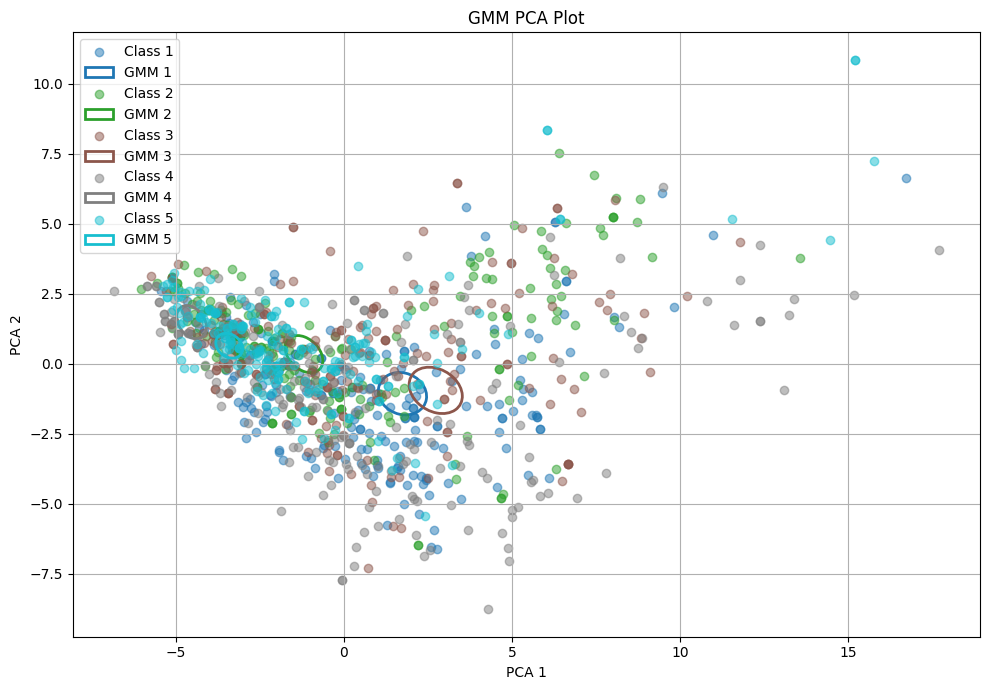

In [ ]:
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA

def plot_gmm_pca(X, y, gmms, title='GMM PCA Plot'):
    print("📊 Projecting to 2D with PCA for visualization...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 7))
    colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(y))))

    for i, label in enumerate(np.unique(y)):
        points = X_pca[y == label]
        plt.scatter(points[:, 0], points[:, 1], label=f'Class {label}', alpha=0.5, c=colors[i:i+1])

        gmm = gmms[label]
        mean_pca = pca.transform(gmm.means_)
        cov_full = gmm.covariances_[0]

        # Transform GMM mean to PCA space
        mean_2d = pca.transform([gmm.means_[0]])[0]

        # Covariance transformation: W * C * W^T
        W = pca.components_
        cov_pca = W @ np.diag(cov_full) @ W.T
        v, w = np.linalg.eigh(cov_pca)
        angle = np.degrees(np.arctan2(w[1, 0], w[0, 0]))
        ell = Ellipse(xy=mean_2d, width=2 * np.sqrt(v[0]), height=2 * np.sqrt(v[1]),
                      angle=angle, edgecolor=colors[i], fc='None', lw=2, label=f"GMM {label}")
        plt.gca().add_patch(ell)

    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call it here:
plot_gmm_pca(X_train, y_train, train_gmms(X_train, y_train))


Training GMMs for each class...
Class 1: 220 samples
Class 2: 220 samples
Class 3: 220 samples
Class 4: 220 samples
Class 5: 220 samples


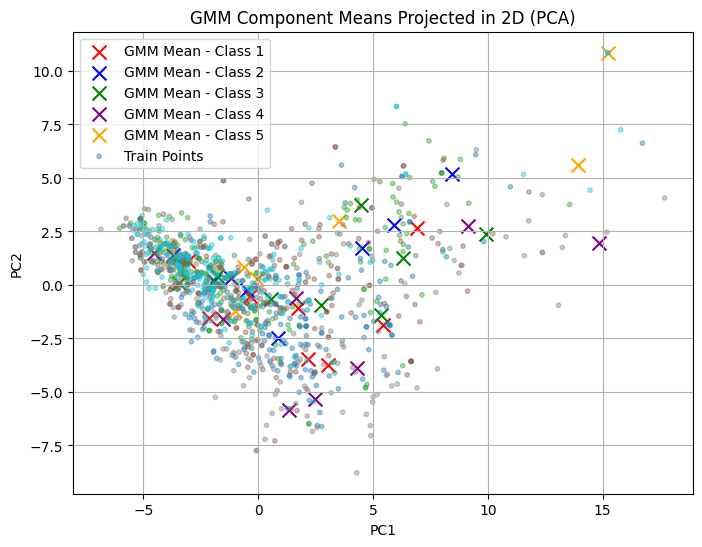

In [ ]:
from sklearn.decomposition import PCA

# Project to 2D for visualization
pca = PCA(n_components=2)
X_proj = pca.fit_transform(X_train)

plt.figure(figsize=(8,6))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']

# Project GMM means
gmms = train_gmms(X_train, y_train)
for idx, (label, gmm) in enumerate(gmms.items()):
    mean_2d = pca.transform(gmm.means_)
    plt.scatter(mean_2d[:,0], mean_2d[:,1], label=f'GMM Mean - Class {label}', marker='x', s=100, color=colors[idx % len(colors)])

plt.scatter(X_proj[:,0], X_proj[:,1], c=[int(i) for i in y_train], cmap='tab10', alpha=0.4, s=10, label='Train Points')
plt.title("GMM Component Means Projected in 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

Training GMMs for each class...
Class 1: 220 samples
Class 2: 220 samples
Class 3: 220 samples
Class 4: 220 samples
Class 5: 220 samples


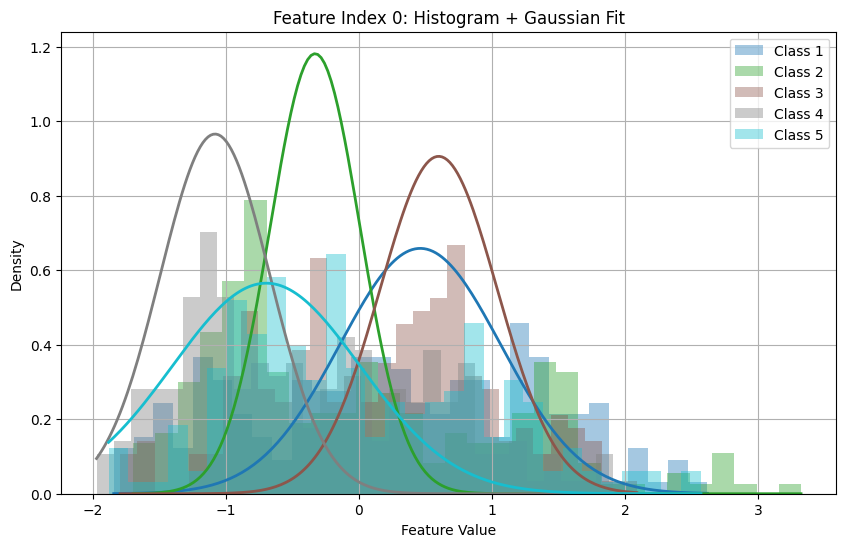

Training GMMs for each class...
Class 1: 220 samples
Class 2: 220 samples
Class 3: 220 samples
Class 4: 220 samples
Class 5: 220 samples


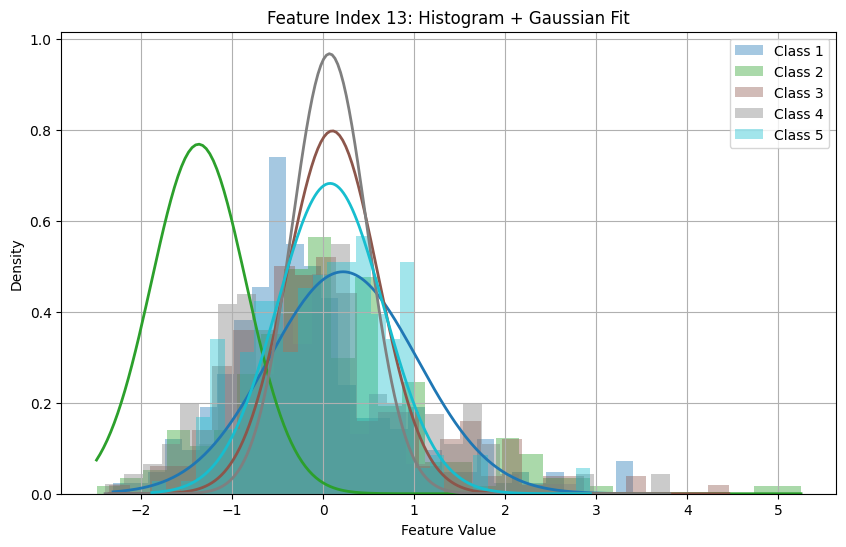

Training GMMs for each class...
Class 1: 220 samples
Class 2: 220 samples
Class 3: 220 samples
Class 4: 220 samples
Class 5: 220 samples


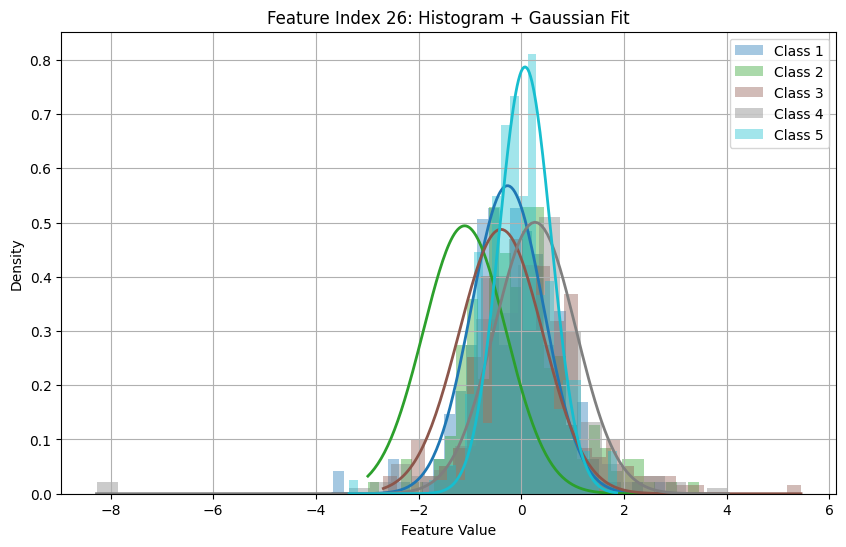

In [ ]:
def plot_gmm_1d_histograms(X, y, gmms, feature_idx=0):
    plt.figure(figsize=(10, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(y))))

    for i, label in enumerate(np.unique(y)):
        X_class = X[y == label]
        feature_vals = X_class[:, feature_idx]

        # Histogram
        plt.hist(feature_vals, bins=30, density=True, alpha=0.4, color=colors[i], label=f'Class {label}')

        # GMM fitted Gaussian
        gmm = gmms[label]
        mean = gmm.means_[0][feature_idx]
        std = np.sqrt(gmm.covariances_[0][feature_idx])
        x_range = np.linspace(feature_vals.min(), feature_vals.max(), 200)
        gauss_pdf = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_range - mean) / std)**2)
        plt.plot(x_range, gauss_pdf, color=colors[i], lw=2)

    plt.title(f"Feature Index {feature_idx}: Histogram + Gaussian Fit")
    plt.xlabel("Feature Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

# Try this for a few features:
plot_gmm_1d_histograms(X_train, y_train, train_gmms(X_train, y_train), feature_idx=0)
plot_gmm_1d_histograms(X_train, y_train, train_gmms(X_train, y_train), feature_idx=13)  # Δ
plot_gmm_1d_histograms(X_train, y_train, train_gmms(X_train, y_train), feature_idx=26)  # ΔΔ
